In [441]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import re

from scripts import *

#palette used in the notebook
colors = (
    '#49393B',
    '#EEC584',
    '#E3EBFF',
    '#55868C',
    '#122932')

colors2 = ("#355070", "#6d597a", "#b56576", "#e56b6f", "#eaac8b")

In [442]:
hn = pd.read_csv("hero-network.csv")
e = pd.read_csv("edges.csv")
nodes = pd.read_csv("nodes.csv")

## Preprocessing

In [443]:

def cleaning(string):
    #Pattern for backlash in last position
    pattern = "\/$" 
    newS = re.sub(pattern, "", string)

    #pattern for space in last position
    pattern =  " $"
    newS = re.sub(pattern, "", newS)
    
    return newS

In [444]:
#Extract all the names from the edges
vecHeroRight = e.hero.unique()
cleanHeroRight = set(map(cleaning, vecHeroRight))

#Extract all the names of the heroes that might be wrong (col hero1)
vecHeroWrong = hn.hero1.unique()
newVecHeroWrong = set(map(cleaning, vecHeroWrong))

#Extract all the names of the heroes that might be wrong (col hero2)
vecHeroWrong2 = hn.hero2.unique()
newVecHeroWrong2 = set(map(cleaning, vecHeroWrong2))

#Merge 
mergeHeroWrong = newVecHeroWrong.union(newVecHeroWrong2)

Since the problem with the hero name string, is just a problem of string limits. All the wrong hero names should be contained in the right hero names.


In [445]:
dic = {}
#Iterate over the wrong hero names
for x in mergeHeroWrong:
    
    #Iterate over the right hero names
    for y in cleanHeroRight:
        dic[x] = x
        if x in y and y not in mergeHeroWrong:
            dic[x] = y
            break

In [446]:
#Clean the values in both columns
hn.hero1 = hn.hero1.apply(lambda row: cleaning(row))
hn.hero2 = hn.hero2.apply(lambda row: cleaning(row))

#Replace the wrong names with the right ones
hn["hero1"] = hn.hero1.apply(lambda row: dic[row])
hn["hero2"] = hn.hero2.apply(lambda row: dic[row])

#Clean the values in nodes.node
nodes.node =  nodes.node.apply(lambda row: cleaning(row))

#remove rows with same values to hero1 and hero2
hn_final = hn[hn.hero1 != hn.hero2]

## First Graph

In [447]:
#reset index of hn_final
hn_final = hn_final.sort_values(by = ['hero1', 'hero2']).reset_index(drop = True)

#create a mask to order them in the same col
mask = hn_final['hero1'] > hn_final['hero2']

#swap the values in those rows
hn_final.loc[mask, ['hero1', 'hero2']] = hn_final.loc[mask, ['hero2', 'hero1']].values

#create a temporary copy of hn_final
hn_temp = hn_final

#group by ["hero1" and "hero2"] and use cumcount to count every edges
hn_final['Number'] = hn_final.groupby(['hero1', 'hero2']).cumcount().add(1)

#sort our values
hn_final = hn_final.sort_values(by = 'Number', ascending = False)

#drop duplicates
hn_final = hn_final.drop_duplicates(subset = ['hero1', 'hero2'], keep = 'first')

#create score base on (1/number of collaboration)
hn_final['Number'] = hn_final['Number'].apply(lambda x: 1/x)

#merge
hn_final = pd.merge(hn_temp, hn_final, on=['hero1','hero2'])

#drop duplicates column
hn_final.drop('Number_x', axis=1, inplace= True)


In [448]:
hn_final.rename(columns={"Number_y":"weight"}, inplace=True)
hn_final.drop_duplicates(inplace=True)
hn_final.sort_values(by="weight")

,hero1,hero2,weight
418453,MISS AMERICA/MADELIN,PATRIOT/JEFF MACE,0.000528
312138,HUMAN TORCH/JOHNNY S,THING/BENJAMIN J. GR,0.001344
309210,HUMAN TORCH/JOHNNY S,MR. FANTASTIC/REED R,0.001403
430641,MR. FANTASTIC/REED R,THING/BENJAMIN J. GR,0.001412
324031,INVISIBLE WOMAN/SUE,MR. FANTASTIC/REED R,0.001427
...,...,...,...
322619,BLACK KNIGHT V DOPPE,INVISIBLE WOMAN/SUE,1.000000
322618,BLACK KNIGHT III/EOB,INVISIBLE WOMAN/SUE,1.000000
322617,"BEYNON, DR. BRADLEY",INVISIBLE WOMAN/SUE,1.000000
322567,INVISIBLE WOMAN DOPP,SASQUATCH/WALTER LAN,1.000000


Il seguente è il grafo con il collegamento tra gli eroi con il relativo peso dato dall'inverso del numero di volte che hanno collaborato

In [449]:
#convert to numpy
edges = hn_final.to_numpy()

#create empty graph
G = nx.Graph()

#add edges and relatives nodes from the couple (hero1, hero2)
G.add_weighted_edges_from(edges)

## Second Graph

In [450]:
hero = nodes[nodes.type=="hero"]
hero.drop("type", axis=1, inplace=True)


C:\Users\matteo\AppData\Local\Temp\ipykernel_4816\2443088000.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hero.drop("type", axis=1, inplace=True)


In [451]:
nodes[nodes.node == "SPIDER-MAN/PETER PARKERKER"]

,node,type
14618,SPIDER-MAN/PETER PARKERKER,hero


In [452]:
nodes.loc[14618].node = "SPIDER-MAN/PETER PARKER"
nodes[nodes.node == "SPIDER-MAN/PETER PARKER"]

,node,type
14618,SPIDER-MAN/PETER PARKER,hero


In [453]:
#Create empty graph
G2 = nx.Graph()

#Preprocess info for heroes
hero = nodes[nodes.type=="hero"]
hero.drop("type", axis=1, inplace=True)

#Add hero nodes
G2.add_nodes_from(hero.node, type= "hero")

#Preprocess info for comic
comic = nodes[nodes.type=="comic"]
comic.drop("type", axis=1, inplace=True)

#Add comic nodes
G2.add_nodes_from(comic.node, type= "comic")

#Preprocess info for edges
a = e.to_numpy()

#Add edges
G2.add_edges_from(a)

C:\Users\matteo\AppData\Local\Temp\ipykernel_4816\2569478207.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  hero.drop("type", axis=1, inplace=True)
C:\Users\matteo\AppData\Local\Temp\ipykernel_4816\2569478207.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comic.drop("type", axis=1, inplace=True)


In [454]:
# TODO: elimina avvisi

## Functionality 1

In [455]:
def functionality1(graph, typeG, edges, NHeroes = None):
    
    #select subGraph if specified
    if NHeroes != None:
        
        #Then we find the top N Nodes/Heroes
        N = NHeroes
        topN = findNHeroes(edges, N)

        if typeG == 1:
            #Create the new subgraph from the topN heroes
            graph = graph.subgraph(topN)
        else:
            #take the subset of the graph with all the relatives edges and nodes
            graph = graph.edge_subgraph(graph.edges(topN))

    #1st point: number of nodes in network
    numberNodes = findNNodes(graph, typeG, edges)

    #2nd and 3rd point (based on typeG): number of collaboration/number of heroes
    nCollaboration = findNCollaboration(graph, typeG)

    #4th point: network density
    density = nx.density(graph)

    #5th point: degree distribution
    degreeDist = nx.degree_histogram(graph)

    #6th point: average degree
    tempDegree = dict(graph.degree()).values()
    averageDegree = round(sum(tempDegree)/len(tempDegree),2)

    #7th point: networks hubs
    hubs = findNetworksHub(graph, typeG, degreeDist)

    #8th point: sparse or dense?
    isDense = True if density > 0.5 else False

            
            

    return numberNodes, nCollaboration, density, degreeDist, averageDegree, hubs, isDense

## Visualization 1

In [456]:
numberNodes, nCollaboration, density, degreeDist, averageDegree, hubs, isDense = functionality1(G,1, e, 120)

### A table containing the following general information about the graph:

- Number of nodes in the network
- Density of the network
- Average degree of the network
- Whether the network is sparse or dense

In [457]:
from tabulate import tabulate

#select col names
col_names = ["Number of nodes","Density","Average degree","Dense"]

#create dictionary 
data = {'Number of nodes':[numberNodes], 'Density':[density],'Average degree':[averageDegree],'Dense':[isDense]}
print(tabulate(data, headers=col_names,  tablefmt="fancy_grid"))

╒═══════════════════╤═══════════╤══════════════════╤═════════╕
│   Number of nodes │   Density │   Average degree │ Dense   │
╞═══════════════════╪═══════════╪══════════════════╪═════════╡
│               119 │  0.759578 │            89.63 │ True    │
╘═══════════════════╧═══════════╧══════════════════╧═════════╛


### A table that lists the network's hubs

In [458]:
from tabulate import tabulate
col_names = ["Hubs"]
data = {'Hubs': hubs}
print(tabulate(data, headers=col_names,  tablefmt="fancy_grid"))

╒═════════════════════════╕
│ Hubs                    │
╞═════════════════════════╡
│ SPIDER-MAN/PETER PARKER │
├─────────────────────────┤
│ HUMAN TORCH/JOHNNY S    │
├─────────────────────────┤
│ MR. FANTASTIC/REED R    │
├─────────────────────────┤
│ CAPTAIN AMERICA         │
╘═════════════════════════╛


### A plot depicting the number of collaborations of each hero in descending order (if the graph is type 1) / A plot depicting the number of heroes who appeared in each comic, sorted in descending order (if the graph is type 2)

In [459]:
sort_col = sorted(nCollaboration, key=lambda item: item[1], reverse=True)[:30]

In [460]:
#TODO: add theme to plots
#TODO: add figsize

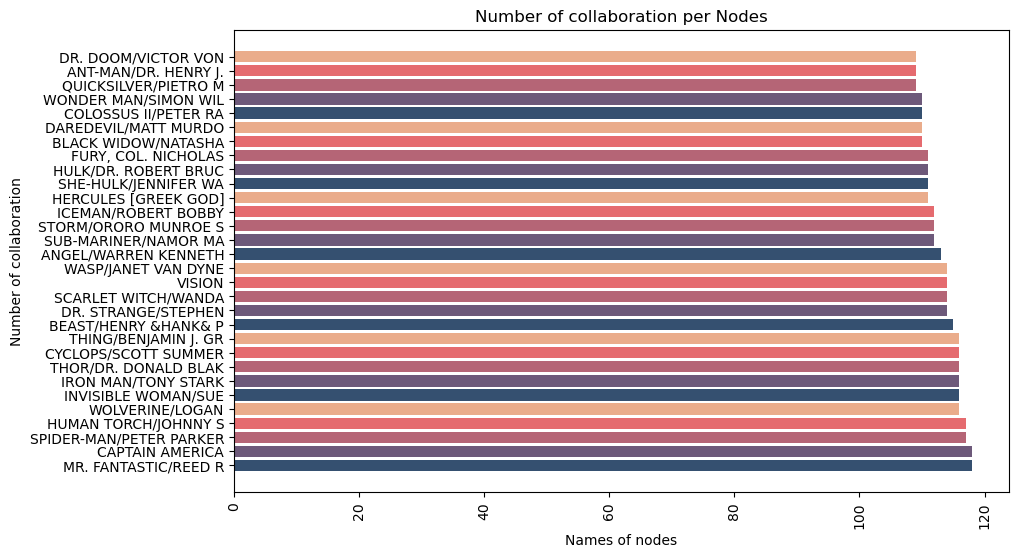

In [461]:
plt.figure(figsize = (10,6))
plt.barh(*zip(*sort_col), color = colors2)
plt.xticks(rotation=90)
plt.title("Number of collaboration per Nodes")
plt.ylabel("Number of collaboration")
plt.xlabel("Names of nodes")
plt.show()

### A plot depicting the degree distribution of the network

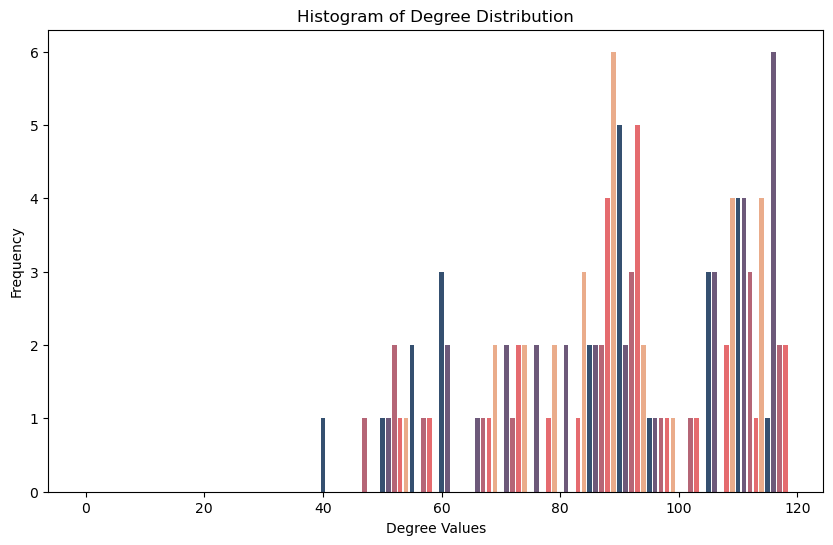

In [462]:
plt.figure(figsize = (10,6))
plt.bar(range(len(degreeDist)), degreeDist, color = colors2)
plt.title("Histogram of Degree Distribution")
plt.xlabel("Degree Values")
plt.ylabel("Frequency")
plt.show()

## Functionality 2

In [463]:
def functionality_2 (graph,metric, node, n_heroes = None):
    global whole_output

    if n_heroes is not None:
        n = findNHeroes(df_edges,n_heroes)

    if metric == 'Betweenness':
        betweenness = nx.betweenness_centrality(graph,k=10, seed=1234, weight='weight')

        output = pd.DataFrame.from_dict(betweenness, orient='index',
                               columns=['Betweenness']).sort_values(by='Betweenness', ascending=False)
        try:
            whole_output = output.loc[n,:].sort_values(by='Betweenness',ascending=False)
            return output.loc[node,:], whole_output
        except:
            return output.loc[node,:], output
    if metric == 'ClosenessCentrality':
        closeness = nx.closeness_centrality(graph,distance='weight')
        output = pd.DataFrame.from_dict(closeness, orient='index',
                               columns=['Closeness']).sort_values(by='Closeness', ascending=False)
        try:
            whole_output = output.loc[n,:].sort_values(by='Closeness',ascending=False)
            return output.loc[node,:], whole_output
        except:
            return output.loc[node,:], output

    if metric == 'PageRank':
        pagerank = nx.pagerank(graph, weight='weight')
        output = pd.DataFrame.from_dict(pagerank, orient='index',
                               columns=['PageRank']).sort_values(by='PageRank', ascending=False)
        try:
            whole_output = output.loc[n,:].sort_values(by='PageRank',ascending=False)
            return output.loc[node,:], whole_output
        except:
            return output.loc[node,:], output

    if metric == 'DegreeCentrality':
        degree = nx.degree_centrality(graph)
        output = pd.DataFrame.from_dict(degree, orient='index',
                               columns=['DegreeCentrality']).sort_values(by='DegreeCentrality', ascending=False)
        try:
            whole_output = output.loc[n,:].sort_values(by='DegreeCentrality',ascending=False)
            return output.loc[node,:], whole_output
        except:
            return output.loc[node,:], output

## Visualization 2

In [464]:
def visualization_2(graph, metric, node, n_heroes=None):

    given_node, out = functionality_2(graph,metric,node,n_heroes)

    df = pd.DataFrame(given_node)

    df['Average'+ f' {metric} '+'measure'] = float(out.values.mean())

    return df

## Functionality 3

In [465]:
def functionality3(graph, heroes, startNode, endNode, N=None):
    #select subGraph if specified
    if N != None:
        
        #Then we find the top N Nodes/Heroes
        topN = findNHeroes(e, N)

        #take the subset of the graph with all the relatives edges and nodes
        graph = graph.edge_subgraph(graph.edges(topN))
    
    couple = (startNode, heroes[0])
    walk = []
    
    for x in range(len(heroes)+1):
        if x == len(heroes):
            couple = heroes[-1], endNode
            
        #the one implemented by the libray
        #walk += nx.shortest_path(graph, couple[0], couple[1])

        #the one implemented by us
        walk += (findShortestPath(graph, couple))
        if x < len(heroes)-1:
            couple = (heroes[x], heroes[x+1])

    return walk

## Visualization 3

### Print the comics in the shortest walk in order

In [466]:
heroes = ["BLACK WIDOW/NATASHA","CAPTAIN AMERICA", "HUMAN TORCH/JOHNNY S", "HULK/DR. ROBERT BRUC"]
path = functionality3(G2, heroes, "SPIDER-MAN/PETER PARKER", "IRON MAN/TONY STARK")

### Plot the graph and identify the nodes and edges that appear in the shortest walk (please put an identifier on each edge in the shortest walk to determine the order that we should have the walk)

In [467]:
def visualize3(graph, heroes, startNode, endNode, N=None, m = True):
    # Get the results for the functionality
    path = functionality3(graph, heroes, startNode, endNode, N)
    # Print the shortest path (only the comics)
    print('Comics in the shortest walk:', path[1::3])
    del path[3::3]

    col1 = colors2[0]
    col2 = colors2[-1]
    col3 = colors2[2]

    if m:
        # Create a new directed graph to show the walk
        G = nx.DiGraph()
        # Add the edges
        for i in range(len(path)-1):
            G.add_edge(path[i],path[i+1])
        
        # And add the nodes
        G.add_nodes_from(path)

        plt.tight_layout()
        # Set the colors of the nodes
        node_colors = [col2 if node == startNode else col2 if node == endNode else col1 for node in G]
        # Draw the graph
        nx.draw(G, pos = nx.layout.spring_layout(G), with_labels = True, node_color=node_colors , alpha = 0.8, font_size=8,
                            arrowsize=15, connectionstyle='arc3,rad=0.05', node_size = 800)
        
    else:
        # Select the subgraph from the edges
        path_graph = graph.edge_subgraph(graph.edges(comics))
        # Define the label that we want to show in the graph
        labels = define_labels(path_graph, path)
        # And find the edges crossed during the walk
        f3_edge = find_edges(path)

        # Set the color of the nodes and edges
        node_colors = [col2 if node == startNode else col2 if node == endNode else col1 if node in path else col3 for node in path_graph]
        edge_colors = ["black" if e in f3_edge else  "lightgray" for e in list(path_graph.edges)]

        # Draw the graph
        nx.draw(path_graph, pos=nx.spring_layout(path_graph), edge_color = edge_colors, with_labels = True, alpha = 0.8, font_size=8, 
                            arrowsize=15, connectionstyle='arc3,rad=0.05', labels= labels, node_color= node_colors)

Comics in the shortest walk: ['SS3 93', 'A 176', 'H 11', 'SS3 96', 'H 11']


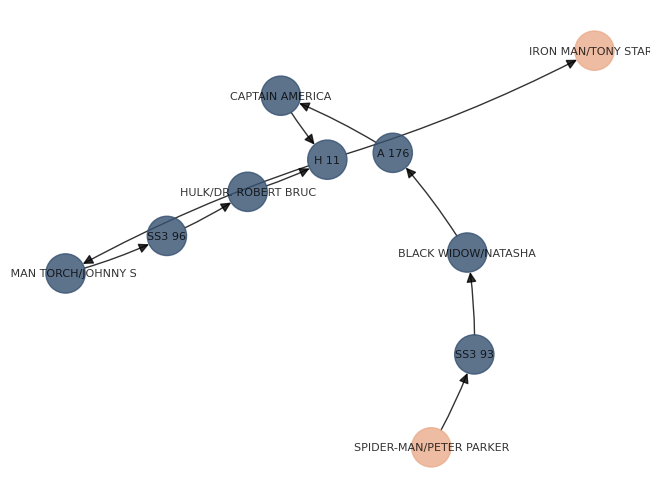

In [468]:
visualize3(G2, heroes, "SPIDER-MAN/PETER PARKER", "IRON MAN/TONY STARK",m = True)

## Functionality 4

In [469]:
def functionality_4(graph,source,target,top_n = None):
    if top_n is not None:
        n = set(findNHeroes(e, top_n)) ## denoting the top N heroes that our algorithm should be considered

    G = graph.copy()
    F = nx.subgraph(G,n) ## creating the subgraph with the top N heroes
    H = F.copy()

    cutset = nx.minimum_edge_cut(H,s=source,t=target) ## the set of the minimum number of edges to disconnect the source from the target
    H.remove_edges_from(cutset) ## remove the cutset from the original graph



    sub_source_edges = set(bfs_unweighted(H,source = source))
    sub_target_edges = set(bfs_unweighted(H,source = target))

    sub_source, sub_target = nx.Graph(), nx.Graph()
    sub_source.add_edges_from(sub_source_edges)
    sub_target.add_edges_from(sub_target_edges)

    return (cutset),F, H, sub_source, sub_target

## Visualization 4

In [470]:
def visualization_4(graph,source,target,top_n = None):
    cutset,G_connected, G_disconnected, sub_source, sub_target = functionality_4(graph,source,target,top_n)
    cut = nx.Graph()
    cut.add_edges_from(cutset)
    H = nx.difference(G_connected,cut)

    col1 = colors2[0]
    col2 = colors2[-1]
    col3 = colors2[2]

    print(f'The minimum number of the links that should be disconnected in order to get two disconnected sub-graphs is {len(cutset)}')

    fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 15))
    pos = nx.circular_layout(G_connected)

    nodes = [col2 if (node == source or node == target) else col1 for node in G_connected.nodes()]
    nx.draw(G_connected,pos,with_labels=True,ax=ax1,node_color = nodes, font_size=8, edge_color="lightgray", alpha = 0.8)
    nx.draw(H,pos,with_labels=True,ax=ax2, node_color = nodes, font_size=8, edge_color="lightgray", alpha = 0.8)
    ax1.set_title('Plot of the original graph', fontweight = 'bold', size = 15)
    ax2.set_title('Plot of the graph after removing the links between the two nodes identified', fontweight = 'bold', size = 15)
    plt.show()

The minimum number of the links that should be disconnected in order to get two disconnected sub-graphs is 14


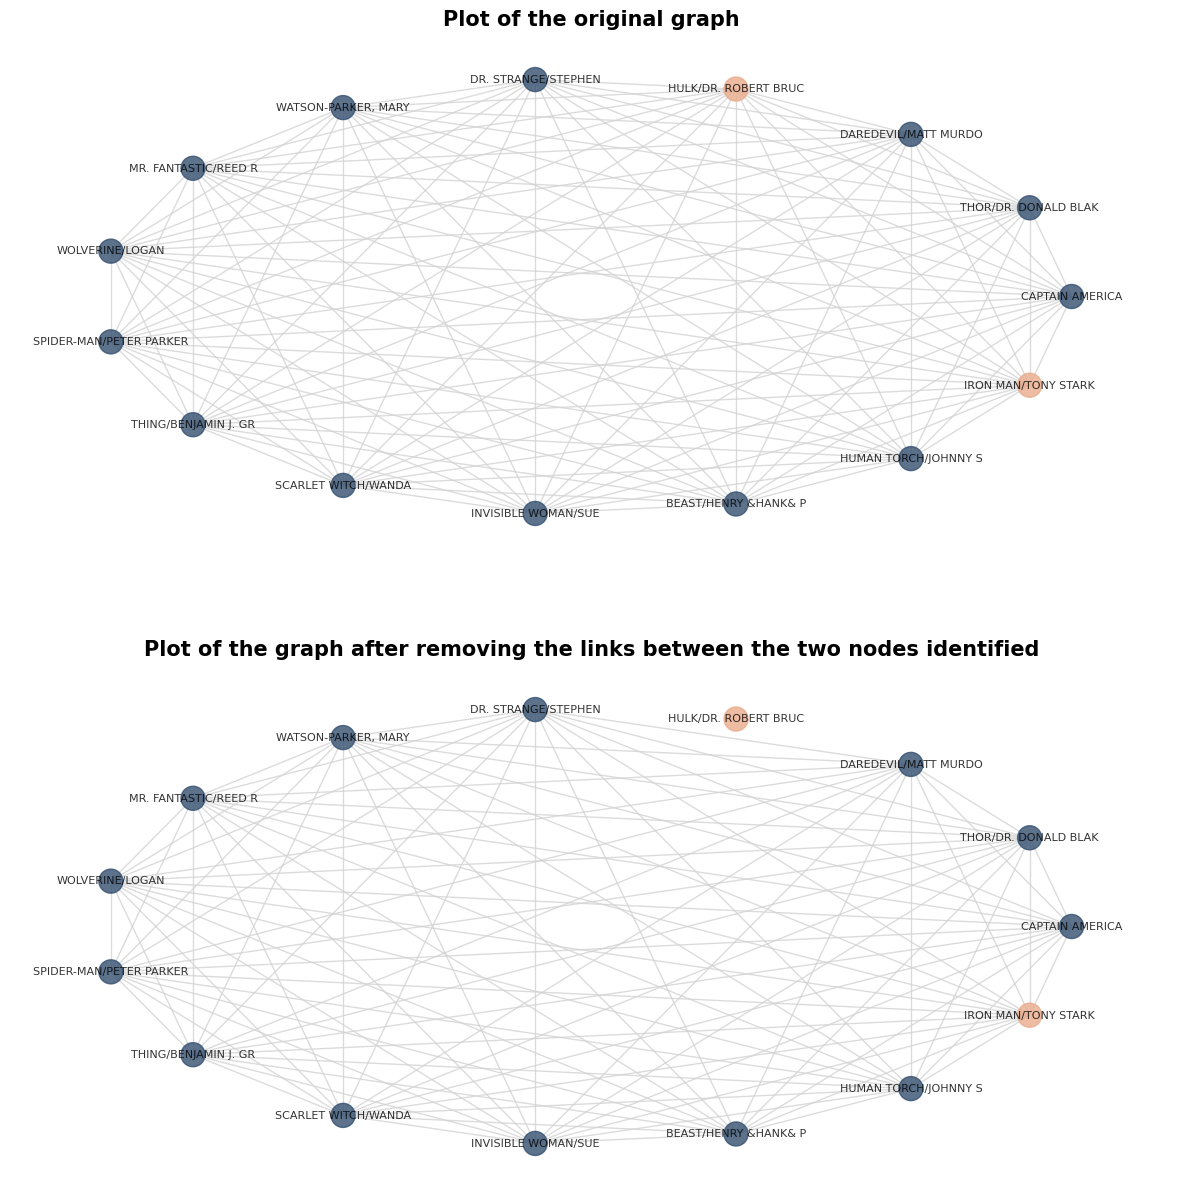

In [471]:
visualization_4(G,'IRON MAN/TONY STARK','HULK/DR. ROBERT BRUC',top_n=15)

## Functionality 5

In [526]:
def functionality5(graph, hero1, hero2, N=None):
  #Variable used to determine if hero1 is in the same community as hero2
  sameCom = False

  #Then we find the top N Nodes/Heroes
  topN = findNHeroes(e, N)

  #Create the new subgraph from the topN heroes
  graph2 = graph.subgraph(topN)
  
  # find communities in the graph
  c, edge_count, graph_copy = girvan_newman(graph2.copy(), 2)

  #for every community in c
  node_groups = list(map(list, list(c)))

  Heroes_com = []
  #Check if hero1 and hero2 are in the same community
  for i in node_groups:
    if hero2 in i:
      Heroes_com.append(i)
    if hero1 in i:
      Heroes_com.append(i)

  return edge_count, node_groups, graph2, Heroes_com, graph_copy

## Visualization 5

In [527]:
hero1 = 'CAPTAIN AMERICA'
hero2 = "IRON MAN/TONY STARK"
edge_count, node_groups, graph2, Heroes_com, graph_copy = functionality5(G, hero1, hero2, N = 40)

### Minimum number of edges needed to create community

In [528]:
edge_count

344

### Plot the graphs

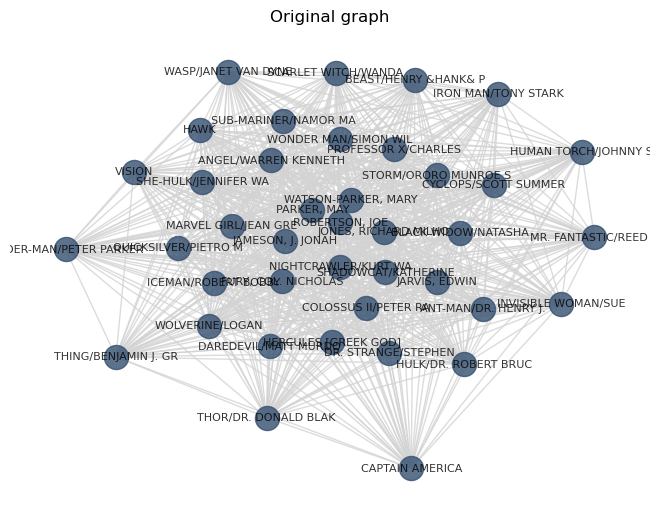

In [529]:

col1 = colors2[0]
col2 = colors2[-1]
col3 = colors2[2]


#plot
nx.draw(graph2, with_labels=True, pos=nx.spring_layout(graph2), font_size=8, edge_color="lightgray", node_color = col1, alpha = 0.8)
plt.title('Original graph')
plt.show()

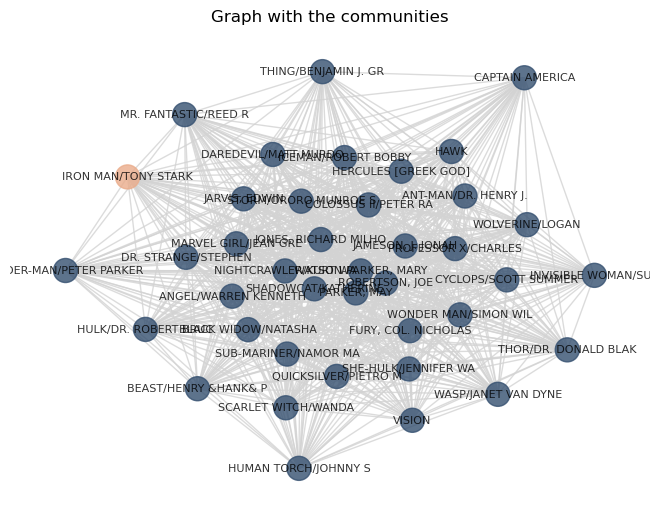

In [530]:
# plot the communities
color_map = []

#function to assign color
#iterate over every node
for node in graph2:
    if node in node_groups[0]:
        color_map.append(col1)
    elif node in node_groups[1]:
        color_map.append(col2)

#plot
nx.draw(graph2, node_color=color_map, with_labels=True, font_size=8, edge_color="lightgray", alpha = 0.8, pos=nx.spring_layout(graph2))
plt.title('Graph with the communities')
plt.show()

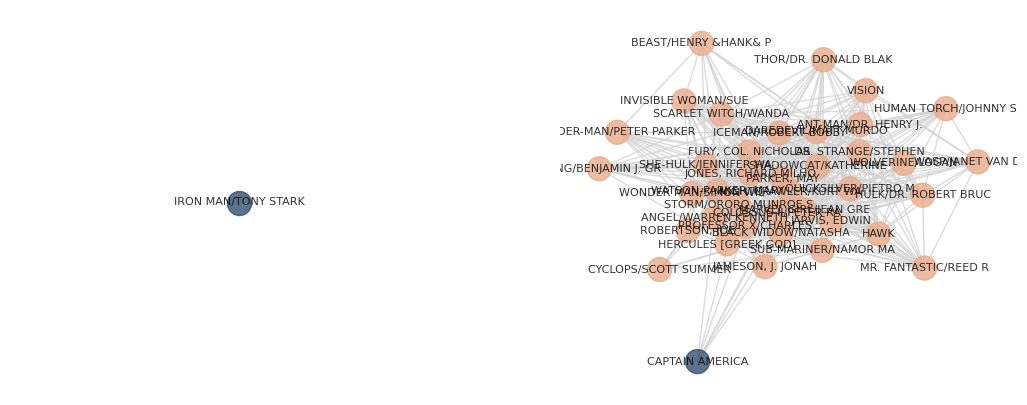

In [531]:
# plot the communities
if len(Heroes_com)==2 and Heroes_com[1] == Heroes_com[0]: 
    newG = graph_copy.subgraph(Heroes_com[0]).copy()
    node_colors = [col1 if node == hero1 else col1 if node == hero2 else col2 for node in newG]

    #plot
    nx.draw(newG, with_labels=True, node_color=node_colors, pos=nx.spring_layout(newG,iterations=42), 
    font_size=8, edge_color="lightgray", alpha = 0.8)
    plt.title('Community containing both '+ str(hero1) + ' and ' +  str(hero2))
else:
    graphs = [graph_copy.subgraph(c).copy() for c in nx.connected_components(graph_copy)]

    #plot
    plt.figure(figsize=(13,5))
    plt.subplot(121)

    node_colors = [col1 if node == hero1 else col1 if node == hero2 else col2 for node in graphs[1]]
    nx.draw(graphs[1], with_labels=True, node_color=node_colors, pos=nx.spring_layout(graphs[1],iterations=42), 
    font_size=8, edge_color="lightgray", alpha = 0.8)

    plt.subplot(122)
    node_colors = [col1 if node == hero1 else col1 if node == hero2 else col2 for node in graphs[0]]
    nx.draw(graphs[0], with_labels=True, node_color=node_colors, pos=nx.spring_layout(graphs[0],iterations=42), 
    font_size=8, edge_color="lightgray", alpha = 0.8)
    plt.show()

## Algorithmic Question

Alex and Sarah have been together for two years, and Alex is now thinking about proposing to her. But, to surprise her, he wants to install an app on her phone that asks her if she will marry him at the right time.

However, to install the application secretly, he needs her phone's password, which he does not have. He knows her password is a poly-line made up of vertical or horizontal line segments. In a 3*3 grid, each line segment connects the centres of two cells. Alex learned the direction of each line segment by looking at her hand while unlocking her phone. He didn't pay much attention to the length of each line segment, but he is sure that her phone's operating system does not allow the poly-line to intersect with itself even at one point.

Alex wants to distract Sarah's attention long enough to test all possible patterns based on the directions of the line segments he has learned. Therefore, he needs you to assist him in calculating how many possible patterns he has to try based on those directions to estimate how much time he needs to check all of those possibilities. Given that the line segments were directed right, down, left, and up, the following figure depicts two valid and one invalid (as the poly-lines should not intersect even in one point) patterns.

### Input:

The input is a single string that shows the direction of the segment lines and contains only the characters R, L, U, and D, which correspond to the Right, Left, Up, and Down directions. The string's maximum length is 10. It is also guaranteed that two consecutive characters will be different.

### Ouput:

We expect to see only 1 number in the output, corresponding to the number of different patterns that can be generated based on the line segments Alex learned. In some cases, this number may be 0, indicating that no patterns can be generated using the learned line segments.

#### Examples:

Input 1 DRU     Output 1  15

Input 2 R       Output 2  9

Input 3 LDRDRUL Output 3  0

### Solution: 

We can give a number from 1 to 9 to each point of the 3x3 grid and create a pandas dataframe to see all the information about the possible movement from each point:

In [532]:
#only to better visualize the possible movement from each point of the grid. For example through the table
#we can see that we can move from point 7 to point 1 with two up movements.

table = pd.DataFrame({'1': ['0', 'L', 'LL','U', '0', '0', 'UU','0', '0'],
                      '2': ['R', '0', 'L', '0', 'U', '0', '0', 'UU','0'],
                      '3': ['RR','R', '0', '0', '0', 'U', '0', '0', 'UU'],
                      '4': ['D', '0', '0', '0', 'L', 'LL','U', '0', '0'],
                      '5': ['0', 'D', '0', 'R', '0', 'L', '0', 'U', '0'],
                      '6': ['0', '0', 'D', 'RR','R', '0', '0', '0', 'U'],
                      '7': ['DD','0', '0', 'D', '0', '0', '0', 'L', 'LL'],
                      '8': ['0', 'DD','0', '0', 'D', '0', 'R', '0', 'L'],
                      '9': ['0', '0', 'DD','0', '0', 'D', 'RR','R', '0']})

table.index = table.index + 1

table

,1,2,3,4,5,6,7,8,9
1,0,R,RR,D,0,0,DD,0,0
2,L,0,R,0,D,0,0,DD,0
3,LL,L,0,0,0,D,0,0,DD
4,U,0,0,0,R,RR,D,0,0
5,0,U,0,L,0,R,0,D,0
6,0,0,U,LL,L,0,0,0,D
7,UU,0,0,U,0,0,0,R,RR
8,0,UU,0,0,U,0,L,0,R
9,0,0,UU,0,0,U,LL,L,0


We decided create a dictionary with all the possible movements from each point of the grid through which we can choose the possible starting points giving the first command: 

In [533]:
#(i,j): position --> (i: number of row (0-2), j: number of column (0-2))

possible_movements = {(0,0): ['R', 'D'], 
                      (0,1): ['L', 'R', 'D'], 
                      (0,2): ['L', 'D'], 
                      (1,0): ['U', 'R', 'D'], 
                      (1,1): ['U', 'L', 'R', 'D'], 
                      (1,2): ['U', 'L', 'D'], 
                      (2,0): ['U', 'R'], 
                      (2,1): ['U', 'L', 'R'], 
                      (2,2): ['U', 'L']}

In [534]:
#Define error message
error = 'Error message: Invalid input or movement'
right = 'Right pattern'

In [535]:
"""
We defined a function that takes as input: 

    -the initial position on the grid
    -list of commands
    -step size for each movement (R,L,D,U)

and gives as output an 'error' message in the case of invalid movement or a 'right' message in case of

valid movements. Invalid movements:

                            -step size out of range
                            -intersecate poly-line
"""

def execute_pattern(position, directions, i ,j ,k ,z):
    
    visited_points = [position] #initialize a list of visited points
    
    for character in directions: #loop over the commands 
    
        if character not in possible_movements[position]: #check if this is a possible movement in that position
        
            return error #return error message
        
        else:  #different case for each command input 'R', 'L', 'U', 'D'
        
            if character == "R": #command right
            
                if position[1] != 2: #cannot go right if we are on the third column
                    
                    if i == 2 and position[1] == 1: #cannot go right with step size 2 if we are in second column
                        
                        return error #return error message
                    
                    else:
            
                        position = (position[0], position[1] + i) #movement to right of step size i
                
                    if position not in visited_points: #check if this position is not in the visited points
                        
                        if i == 1:
                        
                            visited_points.append(position) #flag the point as visited 
                            
                        elif i == 2: 
                            
                            visited_points.append((position[0], position[1] - 1)) #flag as visited the middle point
                                                  
                            visited_points.append(position)
                        
                    else: 
                        
                        return error #return error message
            
                else:
            
                    return error #return error message
        
            elif character == "L": #command left
            
                if position[1] != 0: #cannot go left if we are on the first column
                    
                    if j == 2 and position[1] == 1: #cannot go left with step size 2 if we are in second column
                        
                        return error #return error message
                    
                    else:
                
                        position = (position[0], position[1] - j) #movement to left of step size j
                    
                    if position not in visited_points: #check if this position is not in the visited points
                        
                        if j == 1:
                        
                            visited_points.append(position) #flag the point as visited 
                            
                        elif j == 2: 
                            
                            visited_points.append((position[0], position[1] + 1)) #flag as visited the middle point
                                                  
                            visited_points.append(position) #flag the current point as visited 
                        
                    else: 
                        
                        return error #return error message
                
                else:
                
                    return error #return error message
                
            elif character == "U": #command up
            
                if position[0] != 0: #cannot go up if we are on the first row
                    
                    if k == 2 and position[0] == 1: #cannot go up with step size 2 if we are in second row
                        
                        return error #return error message
                    
                    else:
                
                        position = (position[0] - k, position[1]) #movement up of step size k
                    
                    if position not in visited_points: #check if this position is not in the visited points
                        
                        if k == 1:
                        
                            visited_points.append(position) #flag the point as visited 
                            
                        elif k == 2: 
                            
                            visited_points.append((position[0] + 1, position[1])) #flag as visited the middle point
                                                  
                            visited_points.append(position) #flag the current point as visited
                        
                    else: 
                        
                        return error #return error message
                
                else:
                
                    return error #return error message
                
            elif character == "D": #command down
            
                if position[0] != 2: #cannot go down if we are on the last row
                    
                    if z == 2 and position[0] == 1: #cannot go down with step size 2 if we are in second row
                        
                        return error #return error message
                    
                    else:
                
                        position = (position[0] + z, position[1]) #movement down of step size z
                    
                    if position not in visited_points: #check if this position is not in the visited points
                        
                        if z == 1:
                        
                            visited_points.append(position) #flag the point as visited 
                            
                        elif z == 2: 
                            
                            visited_points.append((position[0] - 1, position[1])) #flag as visited the middle point
                                                  
                            visited_points.append(position) #flag the current point as visited
                        
                    else: 
                        
                        return error #return error message
                
                else:
                
                    return error #return error message
        
    return right, position, visited_points #return 'right pattern message', the final position and the list of vis_points

In [536]:
execute_pattern((0,0), 'RD', 2,1,1,1)  

('Right pattern', (1, 2), [(0, 0), (0, 1), (0, 2), (1, 2)])

In [537]:
"""
This function counts the different pattern, taking as input the initial position and the commands and return 
as output the counter. Given that the user doesn't know the step size but only the directions of the command 
we iterate over all the different combination of step-size. However we decide to create also a list of list 
with all the different pattern as flagged to no double count the same pattern more than one time. 

"""

def count_pattern_fixedpos(position, directions):
    
    count = 0 #initialize counter to zero
    
    different_pattern = [] #initialize list of different pattern to no double-count the same pattern
    
    #cycle on all the different possible stepsize (1-2) for each direction command
    
    for i in range(1,3): #iterate over right step size
        
        for j in range(1,3): #iterate over left step size
            
            for k in range(1,3): #iterate over up step size
                
                for z in range(1,3): #iterate over down step size
                    
                    #check for right pattern and count no repetition
                    if execute_pattern(position, directions, i,j,k,z)[0] == 'Right pattern' and execute_pattern(position, directions, i,j,k,z)[2] not in different_pattern:
                        
                        count += 1 #update counter
                        
                        different_pattern.append(execute_pattern(position, directions, i,j,k,z)[2]) #append the pattern
               
    return count #return the counter 

In [538]:
count_pattern_fixedpos((0,0), 'DRU') #count all the possible pattern starting from point (0,0)

6

In [539]:
""""

This function counts all the different pattern gived the commands. As first step we created a list of possible
initial positions checking if they 'support' the first command of the directions. After that we initialized
a counter that update itself through the function count_pattern_fixedpos. The return is the number of different
patterns.

"""""

def count_patterns(directions): 
    
    #list of the possible initial position checking which position support the first movement
    initial_positions = [key for key in list(possible_movements.keys()) if directions[0] in possible_movements[key]]
    
    #initialize the counter
    num_pattern = 0
    
    for position in initial_positions: #iterate over the positions
        
        num_pattern += count_pattern_fixedpos(position, directions) #update the counter
        
    return num_pattern #return the counter

In [540]:
count_patterns('DRU')

15

In [541]:
count_patterns('R')

9

In [542]:
count_patterns('LDRDRUL')

0

## Command Line

In [543]:
import pandas as pd
cl_hn = pd.read_csv("hero-network.csv")
cl_e = pd.read_csv("edges.csv")

### 1

In [544]:
cl_hn["count"] = 0
cl1 = cl_hn.groupby(by=["hero1", "hero2"]).count().sort_values(by="count")
cl1

count
hero1                hero2                      
24-HOUR MAN/EMMANUEL FROST, CARMILLA           1
MYSTERIO/QUENTIN BEC OKOYE                     1
                     OSBORN, NORMIE            1
                     PALERMO, HARRIET ROS      1
                     PALERMO, VICTOR           1
...                                          ...
THING/BENJAMIN J. GR HUMAN TORCH/JOHNNY S    382
MISS AMERICA/MADELIN PATRIOT/JEFF MACE       627
                     MISS AMERICA/MADELIN    672
PATRIOT/JEFF MACE    MISS AMERICA/MADELIN   1267
                     PATRIOT/JEFF MACE      1275

[224181 rows x 1 columns]

### 2

In [545]:
cl2 = cl_e.groupby(by=["hero"]).count().sort_values(by="comic")
cl2

,comic
hero,
24-HOUR MAN/EMMANUEL,1
FANG,1
FANDRAL | MUTANT X-V,1
"MURRAY, WILLIAM T. B",1
TYPHOON/,1
...,...
THOR/DR. DONALD BLAK,956
THING/BENJAMIN J. GR,963
IRON MAN/TONY STARK,1150


### 3

In [546]:
cl3 = cl_e.groupby(by=["comic"]).count().sort_values(by="hero")


cl3["hero"].sum()

96104

In [547]:
len(cl_e.comic.unique())

12651